The notebook refers the work in this [Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt

--2023-05-08 22:20:34--  https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.005s  

2023-05-08 22:20:35 (44.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt').read().splitlines()
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
# Build vocab of characters and mapping to and from integers
chars = sorted(list(set(''.join(words))))
assert len(chars) == 26

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Data Preparation

In [6]:
# Context Length - How many characters are used to predict the next one
block_size = 3

X, Y = [], []
for w in words[0:5]:

  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)

    print(''.join(itos[i] for i in context), '------>', itos[ix])

    context = context[1:] + [ix]


X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ------> e
..e ------> m
.em ------> m
emm ------> a
mma ------> .
olivia
... ------> o
..o ------> l
.ol ------> i
oli ------> v
liv ------> i
ivi ------> a
via ------> .
ava
... ------> a
..a ------> v
.av ------> a
ava ------> .
isabella
... ------> i
..i ------> s
.is ------> a
isa ------> b
sab ------> e
abe ------> l
bel ------> l
ell ------> a
lla ------> .
sophia
... ------> s
..s ------> o
.so ------> p
sop ------> h
oph ------> i
phi ------> a
hia ------> .


In [7]:
# Example data, label in the dataset
print(X[1], Y[1])

X.shape, X.dtype, Y.shape, Y.dtype

tensor([0, 0, 5]) tensor(13)


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

#### Embedding Matrix

The awesomeness of Pytorch indexing!

In [8]:
# Let's assume we want to embed chars to 2 axes
C = torch.randn((27, 2))

In [9]:
# in order to get the element from C, we can use 2 approaches - 
# 1. Index the tensor, just like python list
# 2. Matrix multiplication -> remember, one-hot matrix when multiplied with another matrix gives the row of interest
# Obviously, it's much faster to just use indexing, and we'll park the idea of matrix multiplication for now
C[5]

tensor([-0.5661, -0.4896])

In [10]:
# But instead of 1 int, we need to index a matrix of shape (27, 2)
# Turns out, Pytorch can take care of this
C[X].shape

torch.Size([32, 3, 2])

2 elements of the embedding matrix for every element (32, 3) of the input

In [11]:
# We can verify

test_output = C[X]

test_row = 3
print('input row: ', X[test_row])
print('embedding matrix row: ', C[X[test_row]])
print('Indexed row: ', test_output[test_row])

input row:  tensor([ 5, 13, 13])
embedding matrix row:  tensor([[-0.5661, -0.4896],
        [ 1.5743,  0.8772],
        [ 1.5743,  0.8772]])
Indexed row:  tensor([[-0.5661, -0.4896],
        [ 1.5743,  0.8772],
        [ 1.5743,  0.8772]])


Matches perfectly!

In [12]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

#### Hidden layer

In [13]:
W1 = torch.randn((6, 100))
# 6 because for every context block of 3 chars, we have 2-dim embedding
# 100 is a hyper-parameter

b1 = torch.randn(100)

In [14]:
# In order to do emb @ W1 + b, we need to re-arrange the matrices
# For now, these are not multipliable
# There are multiple ways in Pytorch to do this

In [15]:
# 1. using cat
torch.cat([emb[:, 0, :] , emb[:, 1, :] , emb[:, 2, :]], 1).shape

# Need to update code everytime when block_size is changes

torch.Size([32, 6])

In [16]:
# 2. using unbind
torch.cat(torch.unbind(emb, 1), 1).shape

# Costly, specially memory wise

torch.Size([32, 6])

In [17]:
# 3. re-arranging using torch internals - update the view of the tensor
emb.view(32, 6).shape

# Fastest and cheapest method of doing this

torch.Size([32, 6])

In [18]:
# Verify if the results are correct
# torch.all checks condition on all element of the tensor
print(torch.all((torch.cat([emb[:, 0, :] , emb[:, 1, :] , emb[:, 2, :]], 1) == torch.cat(torch.unbind(emb, 1), 1)) == True))
print(torch.all((torch.cat([emb[:, 0, :] , emb[:, 1, :] , emb[:, 2, :]], 1) == emb.view(32, 6)) == True))


tensor(True)
tensor(True)


Getting back to the hidden layer

In [19]:
h0 = emb.view(-1, 6) @ W1 + b1 # If -1, pytorch infers the dims
h = torch.tanh(h0)

h.shape

torch.Size([32, 100])

#### Softmax layer and Loss

In [20]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [22]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

# Notice the indexing of probs - we need to extract the probs at that particular Y index
loss = -probs[torch.arange(32),Y].log().mean()
loss

tensor(18.4195)

In [23]:
# The above is just for educational purpose and is rarely used in practice
loss = F.cross_entropy(logits, Y)
loss

tensor(18.4195)

Few reasons
1. Efficient under-the-hood implementation. Pytorch won't create so many additional tensors and save on memory. Also, both forward and backward passes are much more efficient
2. Exp overflow - When input increases in +ve direction, exp() tends to reach inf. Internally, Pytorch subtracts max of the input and avoids inf (since, [10,15,20,25] will have same output as [9,14,19,24])

#### Training Loop

Putting it all together

In [24]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [25]:
g = torch.Generator().manual_seed(10)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

Total trainable parameters:  3481


In [27]:
# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True


In [28]:
for k in range(10):
  # Forward Pass
  emb = C[X]
  h0 = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  for p in parameters:
    p.data += -0.1 * p.grad

Epoch 0 -> Loss = 19.009180068969727 
Epoch 1 -> Loss = 15.267385482788086 
Epoch 2 -> Loss = 12.383593559265137 
Epoch 3 -> Loss = 10.268889427185059 
Epoch 4 -> Loss = 8.576563835144043 
Epoch 5 -> Loss = 7.1071906089782715 
Epoch 6 -> Loss = 5.814657688140869 
Epoch 7 -> Loss = 4.639155387878418 
Epoch 8 -> Loss = 3.6986703872680664 
Epoch 9 -> Loss = 3.0502424240112305 


#### On Complete dataset 

In [29]:
# Context Length - How many characters are used to predict the next one
block_size = 3

X, Y = [], []
for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)

    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [30]:
g = torch.Generator().manual_seed(10)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [31]:
print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

Total trainable parameters:  3481


In [32]:
# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

In [ ]:
for k in range(1000):
  # Forward Pass
  emb = C[X]
  h0 = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)

  if k%100 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  for p in parameters:
    p.data += -0.1 * p.grad

 #### Minibatch

 Instead of training on the entire 200K words, we can achieve similar loss using minibatches of the data

In [36]:
for k in range(1000):

  # Minibatch index
  ix = torch.randint(0, X.shape[0], (32,))


  # Forward Pass
  emb = C[X[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) # Need to update target dataset as well

  if k%100 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  for p in parameters:
    p.data += -0.1 * p.grad

print('Final Loss: ', loss.item())

Epoch 0 -> Loss = 3.5450305938720703 
Epoch 100 -> Loss = 3.2025949954986572 
Epoch 200 -> Loss = 3.067681074142456 
Epoch 300 -> Loss = 2.5491645336151123 
Epoch 400 -> Loss = 2.88202166557312 
Epoch 500 -> Loss = 2.8750674724578857 
Epoch 600 -> Loss = 2.8306124210357666 
Epoch 700 -> Loss = 2.5224947929382324 
Epoch 800 -> Loss = 2.8049681186676025 
Epoch 900 -> Loss = 2.441887140274048 
Final Loss:  2.2467994689941406


That was extremely fast!

#### Learning Rate Selection

In [43]:
# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

Total trainable parameters:  3481


In [44]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre 

So, we start with 0.001 (10\*\*-3) and end at 1 (10**0)

In [45]:
lri, lossi = [], []
for k in range(1000):

  # Minibatch index
  ix = torch.randint(0, X.shape[0], (32,))


  # Forward Pass
  emb = C[X[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix]) # Need to update target dataset as well

  if k%100 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = lrs[k]
  for p in parameters:
    p.data += -lr * p.grad

  lri.append(lr)
  lossi.append(loss.item())

Epoch 0 -> Loss = 19.47472381591797 
Epoch 100 -> Loss = 18.331302642822266 
Epoch 200 -> Loss = 12.095009803771973 
Epoch 300 -> Loss = 11.245638847351074 
Epoch 400 -> Loss = 7.10150146484375 
Epoch 500 -> Loss = 5.959551811218262 
Epoch 600 -> Loss = 2.733177661895752 
Epoch 700 -> Loss = 3.4323627948760986 
Epoch 800 -> Loss = 3.363483190536499 
Epoch 900 -> Loss = 3.488156795501709 


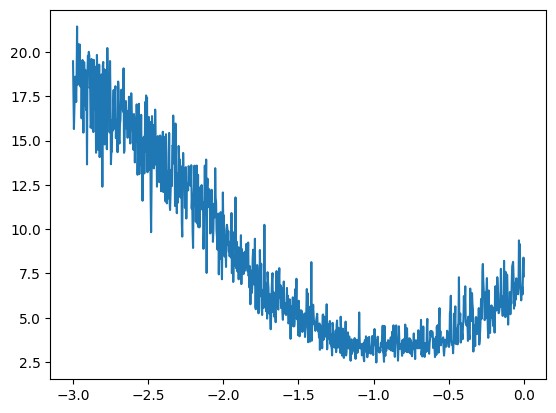

In [46]:
plt.plot(lre, lossi)

So, we can see a good learning rate for the problem lies somewhere in the valley between -1.0 and -0.5

#### Train-Dev-Test Split

In [52]:
import random

def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

# Random shuffle of words
random.seed(42)
random.shuffle(words)
# Training data -> 80%, Val data -> 10%, testing data -> 10%
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

print('Training Data Size: ', len(X_train))
print('Validation Data Size: ', len(X_val))
print('Testing Data Size: ', len(X_test))

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])
Training Data Size:  182424
Validation Data Size:  22836
Testing Data Size:  22886
